# Data science challenge

We are given the following dataset:

In [1]:
import pandas
df = pandas.read_csv("aft100k.csv")
print(df.head(10))

   creative_id user_operating_system       user_device  \
0       113521               Android             Phone   
1       115340               Windows  PersonalComputer   
2       113582               Android             Phone   
3        97385               Windows  PersonalComputer   
4       114821               Windows  PersonalComputer   
5       113065               Android            Tablet   
6       111414                   iOS             Phone   
7       111414                   iOS             Phone   
8       112705               Windows  PersonalComputer   
9       113176                 macOS  PersonalComputer   

   average_seconds_played      cost  revenue  
0                     NaN  0.010128      0.0  
1                0.000000  0.005937      0.0  
2                7.142857  0.004398      0.0  
3                     NaN  0.006157      0.0  
4                     NaN  0.001994      0.0  
5                     NaN  0.003781      0.0  
6               17.000000  0.002

- creative_id: A unique identifier of the video that has been displayed to the user
- user_operating_system: The user Operating System (OS)
- user_device: The user device type
- average_seconds_played: The average number of seconds the user usually watches our videos (only if we already know the user, based on the user history)
- cost: The cost we had to pay to display the video
- revenue: The revenue generated by this video when it has been watched


## Preliminary questions

####  1) The margin being defined as (revenue - cost) / revenue, what is our global margin based on this log?

In [2]:
print("Are there null revenues? {}".format(df["revenue"].isnull().values.any()))
print("Are there null costs? {}".format(df["cost"].isnull().values.any()))

Are there null revenues? False
Are there null costs? False


In [3]:
revs = df["revenue"].sum()
costs = df["cost"].sum()
margin = (revs-costs)/revs
print("Global margin is {0:.4f}, or {1:.2f}%".format(margin, margin*100))

Global margin is 0.2719, or 27.19%


#### 2) Can you think of other interesting metrics to optimize

Metrics to optimize:

1) Profits - No explanation needed.

2) Profits per device - We want to make sure all devices are profitable.

3) Profits per OS - We want to make sure all OSs are profitable.

4) Profits per video - We want to make sure all ads are profitable.

I would also like to understand why sometimes it takes more seconds than others to get the money - some of them don't make us any money in 30 seconds, some of them do in 10 seconds. I guess it is very possible that we are losing money in some type of ads. Maybe we should only display them in certain platforms where people is willing to spend more time watching ads - and this is a metric we could get from our csv, the number of seconds per device.

Moreover, it may be important for our clients two traditional metrics that don't appear in the csv: Click-through rate (CTR) and Conversion rate.



#### 3) What are the most profitable Operating Systems?

In [4]:
df_agg = df[['user_operating_system','cost', 'revenue']].groupby(
    ['user_operating_system']).sum()
series_profits = df_agg["revenue"]-df_agg["cost"]
print("Most profitable OSs:")
display(series_profits.sort_values(ascending=False))

Most profitable OSs:


user_operating_system
iOS              115.521775
Windows           65.873808
Android           27.279364
OS X               1.707775
Chrome OS          0.428130
Linux              0.372922
macOS              0.248021
Fire OS            0.142575
unknown            0.093995
BlackBerry OS      0.077391
BSD                0.040430
RIM OS            -0.005229
dtype: float64

The only real profitability comes from iOS, Windows and Android - anything else is barely profitable.

## Machine learning questions

#### How would you use this historical data to predict the event 'we benefit from a revenue' (i.e. revenue > 0) in a dataset where the revenue is not known yet?

#### Compute the prediction accuracy of a well chosen algorithm and comment the results. Do not hesitate to describe your methodology.

The problem at hand is a problem of supervised learning, in particular, it is a regression problem. We need to build a regressor from our dataset, using:

- Five features: *creative_id, user_operating_system, user_device, average_seconds_played, cost*. 
- A label: *revenues*.
- A regression algorithm


In order to validate our results, we will divide the dataset in 2, training set (80%) and test set (20%). Cross validation with several bags would be a better technique, but it would take longer.

Before doing this, and just in case our data has some hidden time sequentiality, let's shuffle the data.

In [5]:
from sklearn.utils import shuffle

df = shuffle(df)

df_train = df[:len(df)*4//5]
df_test = df[len(df)*4//5:]

##### Feature Generation

Feature generation is one of the most important processes in data science. A good result is accomplished thanks to domain expertise, proper data visualization, and trial and error - but this are in general too time consuming for the scope of the project.

Some interesting features we could investigate are:

1) Interactions: Interaction between the videos (creative_id) and the user device, or with the video and the operating system.

2) Binning: Create bins in case there is some skewness in a variable - for example, in our case, most of the distribution is close to the min.

##### Data cleaning:

The first problem we face is that the features user_device and average_seconds_played are not present in some examples of the data set - or, in pandas' jargon, they are NaNs.

In [6]:
feature_cols = ['creative_id', 'user_operating_system', 'user_device', 
                'average_seconds_played', 'cost']
label_col = ['revenue']

X_train = df_train.loc[:, feature_cols]
y_train = df_train[label_col]

print(X_train.isnull().sum())
print(y_train.isnull().sum())

creative_id                   0
user_operating_system         0
user_device                   5
average_seconds_played    49387
cost                          0
dtype: int64
revenue    0
dtype: int64


In the case of *user_device*, it is not a big problem (only 8 labels out of 100 000, we can discard 8 without any second thoughts). Also substituting the NaNs for the average or something similar is tricky since this is a categorical feature (i.e., a string) - we could use the most frequent value but, again, there is no need. 


In [7]:
y_train = y_train[-X_train["user_device"].isnull()]
X_train = X_train[-X_train["user_device"].isnull()]

In the case of *average_seconds_played*, the problem is different: more than half of the data does not contain a value for the feature. However in this case, this is a numerical feature which gives us two options:

1) Removal: We would end up with around 40% of the dataset. The impact of this could be huge, but at least we are not "tampering" the data.

2) Substituting the data with its average, mode or median. This looks more promising, and it will be our default approach.

It could be interesting to compare the performances of both options, but for the scope of this work lets limit ourselves to the second option.

In [8]:
import numpy as np
from sklearn.preprocessing import Imputer

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
X_train["average_seconds_played"] = imp.fit_transform(X_train[["average_seconds_played"]])

##### Data visualization

Here is some very basic information from the dataset.

In [9]:
X_train.describe()

creative_id  average_seconds_played          cost
count   79995.000000            79995.000000  79995.000000
mean   112156.268667               10.592284      0.005667
std      5250.445087                6.018004      0.003497
min     50634.000000                0.000000      0.000473
25%    112190.000000               10.592284      0.003308
50%    113521.000000               10.592284      0.004837
75%    114948.000000               10.592284      0.006616
max    115465.000000              175.000000      0.052878

Let's use some bar plots for the categorical features:

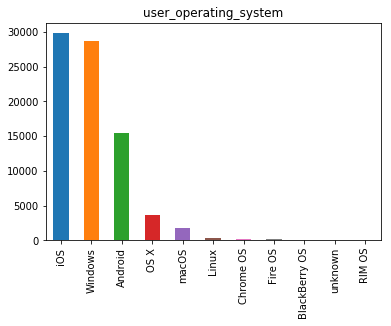

In [10]:
%matplotlib inline

X_train["user_operating_system"].value_counts().plot(kind='bar', title='user_operating_system')

We can see that our sample is mostly with iOS and Windows, and also some Android.

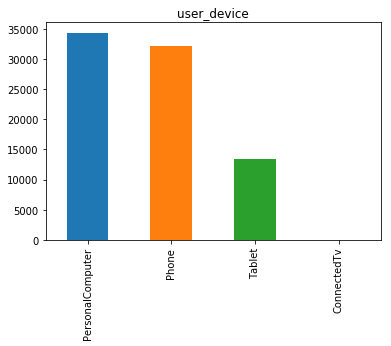

In [11]:
%matplotlib inline

X_train["user_device"].value_counts().plot(kind='bar', title='user_device')


We can appreciate that connected TVs are almost non existent.

For the numerical features, we have the following:

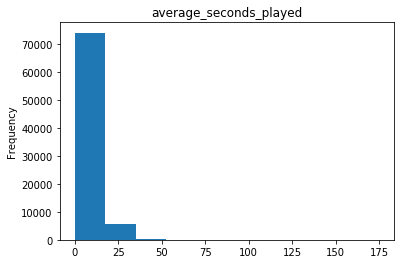

In [12]:
%matplotlib inline

X_train["average_seconds_played"].plot(kind='hist', title='average_seconds_played')

This calls for transformations. Let's try with a log transformation instead, with a logarithmic y-axis for better visualization. 

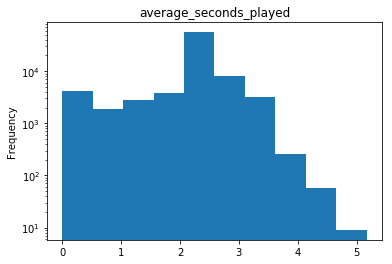

In [13]:
%matplotlib inline

X_train["average_seconds_played"] = pandas.Series(np.log1p(X_train["average_seconds_played"]))
X_train["average_seconds_played"].plot(kind='hist', logy=True, title='average_seconds_played')

This looks more like a normal distribution (actually, like a Laplace distribution due to its high kurtosis).

For the cost, this is what the histogram looks like:

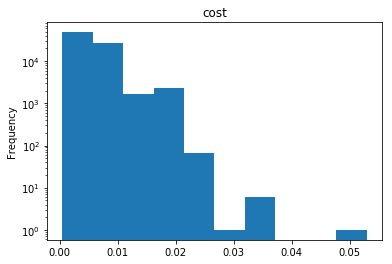

In [14]:
%matplotlib inline

X_train["cost"].plot(kind='hist', logy=True, title='cost')

Again, this calls for transformations. The log transformation does not work well, but the boxcox does.

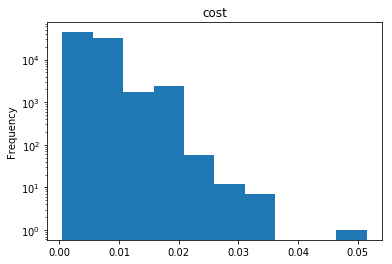

In [15]:
%matplotlib inline

pandas.Series(np.log1p(X_train["cost"])).plot(kind='hist', logy=True, title='cost')

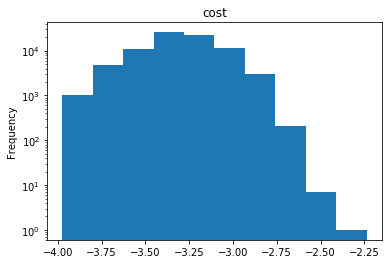

In [16]:
%matplotlib inline

from scipy.stats import boxcox
boxcox, _ = boxcox(X_train["cost"])
boxcox = pandas.Series(boxcox)

boxcox.plot(kind='hist', logy=True, title='cost')

In [17]:
X_train["cost"] = boxcox.values

##### Dealing with categorical features

We also need to encode the categorical features (*user_operating_system, user_device*) in order to feed them to the regressor algorithm. We could use CategoricalEncoder in order to do so, with "one hot" encoding being the preference here (since we don't want the ordering than the "ordinal" encoding brings).

`from sklearn import preprocessing`

`enc = preprocessing.CategoricalEncoder(encoding='onehot')`

However, it is not implemented yet in the version we are using so we will have to do it manually.

In [18]:
def encode_categorical_feature(feature_name, df):
    index_list = df[feature_name].value_counts().axes[0].tolist()
    for index_elem in index_list:
        new_feature_name = "{} {}".format(feature_name, index_elem)
        df[new_feature_name] = df[feature_name]==index_elem
    
    return df.drop(feature_name, axis=1)


X_train = encode_categorical_feature("user_operating_system", X_train)
X_train = encode_categorical_feature("user_device", X_train)

X_train

creative_id  average_seconds_played      cost  \
55871       115119                1.921813 -3.015096   
31849       115221                2.450340 -3.699127   
75917       112798                2.450340 -3.442977   
7527        114811                2.450340 -3.089618   
617          97385                2.130214 -3.226391   
77895       112570                2.450340 -3.285893   
46909       113052                2.450340 -3.492785   
53160       106814                2.450340 -3.226391   
94259       114850                2.450340 -3.807503   
15972        91856                3.496508 -3.346975   
71284       111762                0.000000 -3.053187   
8680        115437                2.501436 -3.398603   
43362       113643                1.252763 -3.032823   
22555       112780                2.450340 -3.549794   
58206       114233                2.140066 -3.267404   
58291       106258                2.450340 -3.256552   
11210       115465                2.450340 -3.422687   
24829       115340                0.916291 -3.089618   
19725       112985                2.106841 -2.866778   
27935       110021                3.274446 -2.849537   
33369       112190                2.197225 -3.346975   
18032       109820                2.302585 -3.492785   
1554        110729                3.367296 -3.032823   
61525       112190                2.611906 -3.346975   
33056       114252                2.450340 -3.032823   
54650       115250                2.450340 -3.392221   
60388        99018                2.450340 -3.346975   
88778       115222                2.407465 -2.794048   
86469       113521                2.450340 -3.032823   
61049       115220                0.000000 -3.089082   
...            ...                     ...       ...   
67157       115227                2.450340 -3.392221   
74253       112898                3.079875 -3.226391   
42366       114227                3.465736 -3.114548   
79485       106258                2.450340 -3.256552   
18833       115119                2.700615 -3.015096   
4989        115245                2.450340 -3.442977   
52062       111413                2.450340 -3.148725   
82268       112190                2.450340 -3.346975   
93187       109682                2.450340 -3.226391   
56662       113730                2.450340 -3.200165   
52782       111503                0.000000 -3.346975   
30337       113631                2.450340 -3.346975   
66694       114233                2.450340 -3.032823   
58670       106258                1.540445 -3.256552   
31808       114395                2.450340 -3.398603   
32174       115245                2.751535 -3.199528   
83406        97391                3.729701 -3.226391   
4034        110729                2.833213 -3.032823   
30601       113650                2.450340 -3.114548   
86686       115189                2.450340 -3.616862   
82432       112570                2.867899 -3.285893   
20177       110724                0.693147 -3.032823   
44673       112779                0.000000 -3.549794   
89202       115465                0.000000 -3.089618   
40961       115245                2.450340 -3.442977   
81430       114165                2.995732 -3.674944   
32870       114849                2.450340 -3.256552   
74221       115167                2.450340 -3.616862   
83173       115464                2.584606 -3.226391   
93660       115437                2.450340 -3.398603   

       user_operating_system iOS  user_operating_system Windows  \
55871                       True                          False   
31849                       True                          False   
75917                       True                          False   
7527                        True                          False   
617                        False                          False   
77895                       True                          False   
46909                      False                          False  

Regarding the feature 'creative_id', we have a problem, since it is numerical, but only in disguise - it is actually categorical, with the numerical values not meaning anything.

We could do several things:

1) We could use one hot encoding. This could provide us of a very good way of identifying the video. However, it also presents some problems:
    - there are too many variables - 926 in the training set.
    - what happens if we want to do this on other videos not in the list?
2) We could use this as a numerical feature. The problem is that there is no meaning in the number.

3) We could ignore the feature.

A rigorous approach would compare the three options, but to make it brief, let's ignore it.

In [19]:
X_train = X_train.drop('creative_id', axis=1)

##### Data Normalization

Now we will standardize the data, as it is important for some machine learning algorithms like SVMs.

In [20]:
# Let's store the means and stds for the test data
numerical_features = ["average_seconds_played", "cost"]
means = X_train[numerical_features].mean()
std = X_train[numerical_features].std()

from sklearn import preprocessing

X_train[numerical_features]=preprocessing.scale(X_train[numerical_features])

print(X_train[numerical_features].mean())
print(X_train[numerical_features].std())
display(X_train.head())

average_seconds_played    1.140215e-15
cost                     -2.762859e-16
dtype: float64
average_seconds_played    1.000006
cost                      1.000006
dtype: float64


average_seconds_played      cost  user_operating_system iOS  \
55871               -0.522865  1.354535                       True   
31849                0.242060 -1.805295                       True   
75917                0.242060 -0.622029                       True   
7527                 0.242060  1.010285                       True   
617                 -0.221251  0.378473                      False   

       user_operating_system Windows  user_operating_system Android  \
55871                          False                          False   
31849                          False                          False   
75917                          False                          False   
7527                           False                          False   
617                            False                          False   

       user_operating_system OS X  user_operating_system macOS  \
55871                       False                        False   
31849                       False                        False   
75917                       False                        False   
7527                        False                        False   
617                          True                        False   

       user_operating_system Linux  user_operating_system Chrome OS  \
55871                        False                            False   
31849                        False                            False   
75917                        False                            False   
7527                         False                            False   
617                          False                            False   

       user_operating_system Fire OS  user_operating_system BlackBerry OS  \
55871                          False                                False   
31849                          False                                False   
75917                          False                                False   
7527                           False                                False   
617                            False                                False   

       user_operating_system unknown  user_operating_system RIM OS  \
55871                          False                         False   
31849                          False                         False   
75917                          False                         False   
7527                           False                         False   
617                            False                         False   

       user_device PersonalComputer  user_device Phone  user_device Tablet  \
55871                         False               True               False   
31849                         False               True               False   
75917                         False               True               False   
7527                          False              False                True   
617                            True              False               False   

       user_device ConnectedTv  
55871                    False  
31849                    False  
75917                    False  
7527                     False  
617                      False

##### Feature Selection

Regarding feature selection, random forests produce a good indicator of which ones are best. The reason they are good is that they into account the interaction between the features when making the decision, and that they are cheap (vs for example recursive feature elimination). In this case we will do it only for the 17 already-existing features, but we should do it for any generated features too.

Feature ranking:
1. feature 0: average_seconds_played (0.575944)
2. feature 1: cost (0.296108)
3. feature 14: user_device Phone (0.020766)
4. feature 3: user_operating_system Windows (0.019297)
5. feature 2: user_operating_system iOS (0.016088)
6. feature 5: user_operating_system OS X (0.014831)
7. feature 15: user_device Tablet (0.013602)
8. feature 6: user_operating_system macOS (0.013017)
9. feature 4: user_operating_system Android (0.009828)
10. feature 13: user_device PersonalComputer (0.008939)
11. feature 7: user_operating_system Linux (0.004206)
12. feature 8: user_operating_system Chrome OS (0.003593)
13. feature 9: user_operating_system Fire OS (0.002641)
14. feature 10: user_operating_system BlackBerry OS (0.000759)
15. feature 11: user_operating_system unknown (0.000263)
16. feature 16: user_device ConnectedTv (0.000113)
17. feature 12: user_operating_system RIM OS (0.000006)


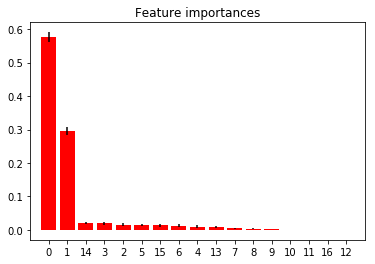

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Build a forest and compute the feature importances
forest = RandomForestRegressor(n_estimators=50)
forest.fit(X_train, y_train["revenue"])

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

index_list = X_train.axes[1].tolist()

for idx in range(X_train.shape[1]):
    feat_name = index_list[indices[idx]]
    print("%d. feature %d: %s (%f)" % (idx + 1, indices[idx], feat_name, importances[indices[idx]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()


The most important feature is, with a big difference, the average_seconds_played. This makes a lot of sense, of course. Also, the cost is an important factor - it makes sense too.

Regarding the influence of the operating system and the user device, it is kind of limited.

It looks like we could safely remove 8 features from 17, or even 12 if we are more aggressive. Let's try and see what's better when we train our model.

##### Training a regressor

For choosing which model is better, we need a metric - in our case we chose metric Pearson's coefficient (R^2), but it could also be the Mean Squared Error or the Mean Average Error.

Unfortunately, I have not managed to get a result better than 20% in the training set, not even the training set.

I have tried with Random Forests, Stochastic Gradient Descent and SVMs.

Random Forests got the best results, but still insufficient. Changing the number of features, adding more forests or introducing variance by making imperfect splits does not give us too much. SGD got 10%, while SVMs didn't work well due to the lack of enough data. A relevant discovery is that the best result is for 5 features.

In [22]:
index_to_drop = []
for idx in range(5, X_train.shape[1]):
    index_to_drop.append(index_list[indices[idx]])

X_train_5 = X_train.drop(index_to_drop, axis=1)

In [23]:
X_train_5
forest = RandomForestRegressor(n_estimators=100)
forest.fit(X_train_5, y_train["revenue"])
forest.score(X_train_5, y_train["revenue"])

0.18694179529917776

In [24]:
from sklearn.linear_model.stochastic_gradient import SGDRegressor

clf = SGDRegressor(max_iter=10000, tol=1e-5)
clf.fit(X_train_5, y_train["revenue"])
clf.score(X_train_5, y_train["revenue"])

0.0090824327401167748

### Conclusion

Due to the limited scope and time available for the challenge, we did not succeed to get a good estimator.

Some things that could be explored:
- Discarding using the average as a substitute for missing *average_seconds_played*, instead remove those examples.
- Use resampling methods with regressors like AdaBoost in order to mitigate the problem with not enough data.
- Explore other data transformations.
- In general, having better features.